<h1><center>seq2seq модели, механизм attention </center></h1>


Рассмотрим работу seq2seq моделей и механизма attention на задаче нормализации дат: на вход подаем даты в произвольном формате, на выход хотим получать их в унифицированном формате.

Мы воспользуемся кодом из туториала PyTorch по машинному переводу: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Генерируем  данные

Сгенерируем даты в разных форматах.

In [4]:
import datetime
from random import randrange
from datetime import timedelta

In [5]:
def get_random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return (start + timedelta(seconds=random_second)).replace(hour=0, minute = 0, second=0)


FORMATS = ['%d %b %Y', '%d %B %Y', '%B %dth, %Y', '%b %d, %Y',
           '%d/%m/%Y', '%d/%m/%y', '%d-%b-%y', '%d.%m.%Y']

TARGET_FORMAT = '%d-%m-%Y'

def get_dataset(fst_dt, snd_dt, fmt_dt):
    fst_d = datetime.datetime.strptime(fst_dt, fmt_dt)
    snd_d = datetime.datetime.strptime(snd_dt, fmt_dt)
    dataset = []
    for i in range(10000):
        date_format = random.choice(FORMATS)
        rand_dt = get_random_date(fst_d, snd_d)
        t = (datetime.datetime.strftime(rand_dt, date_format),
            datetime.datetime.strftime(rand_dt, TARGET_FORMAT))
        dataset.append(t)
    return dataset

dataset = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')

In [6]:
dataset[:10]

[('08.03.2018', '08-03-2018'),
 ('20/11/17', '20-11-2017'),
 ('March 11th, 2017', '11-03-2017'),
 ('12/09/18', '12-09-2018'),
 ('30.05.2017', '30-05-2017'),
 ('21/11/2017', '21-11-2017'),
 ('01-Dec-18', '01-12-2018'),
 ('Sep 22, 2017', '22-09-2017'),
 ('01 Jun 2018', '01-06-2018'),
 ('10 August 2017', '10-08-2017')]

Создаем вспомогательные классы для word2index, index2word

In [7]:
# length of the longest string + EOS
MAX_LENGTH = max(map(lambda x: len(x[0]), dataset)) + 1

In [8]:
MAX_LENGTH

21

In [9]:
SOS_token = 0
EOS_token = 1

# symbol in our case
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS and EOS

    def addSentence(self, sentence):
        for word in list(sentence):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

In [10]:
def readLangs(lang1, lang2):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang


def prepareData(lang1, lang2, pairs):
    input_lang, output_lang = readLangs(lang1, lang2)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('human', 'iso', dataset)
print(random.choice(pairs))
print(input_lang.index2word)

human 43
iso 13
('09/07/2018', '09-07-2018')
{0: 'SOS', 1: 'EOS', 2: '0', 3: '8', 4: '.', 5: '3', 6: '2', 7: '1', 8: '/', 9: '7', 10: 'M', 11: 'a', 12: 'r', 13: 'c', 14: 'h', 15: ' ', 16: 't', 17: ',', 18: '9', 19: '5', 20: '-', 21: 'D', 22: 'e', 23: 'S', 24: 'p', 25: 'J', 26: 'u', 27: 'n', 28: 'A', 29: 'g', 30: 's', 31: 'N', 32: 'o', 33: 'v', 34: 'm', 35: 'b', 36: '6', 37: 'O', 38: '4', 39: 'F', 40: 'y', 41: 'i', 42: 'l'}


### Seq2Seq модель
- модель, состоящая из двух RNN: энкодер и декодер.  Энкодер считывает строку и выдает вектор (закодированная строка), декодер считывает этот вектор и генерирует строку
- в конец исходной строки добавляем EOS-символ (его векторное представление, получающееся после применения энкодер - и есть вектор, который будем подавать в декодер)
- на вход декодер в качестве первого символа подается SOS-символ, а в качестве начального скрытого состояния подается эмбеддинг EOS-символа из энкодер

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
# simple decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, _):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention декодер

Механизм attention позволяет декодеру смотерть на разные части предложения и использовать их в соответствии с выученными весами.

Механизм attention:
- вычисляет набор весов внимания
- умножает их на выход энкодера ("attn_applied")

![image](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [14]:
# attention декодер
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            torch.tanh(self.attn(torch.cat((embedded[0], hidden[0]), 1))), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Обучение
- создаем входные тензоры (с индексами символов) для каждой пары обучающей выборки
- добавляем EOS-символы и в исходную, и в target последовательность

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in list(sentence)]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Используем **teacher forcing** при обучении: при декодировании следующего символа модель будет видеть не сгенерированную на предыдушем шаге последовательность, а настоящую (target). Подробнее можно почитать [тут](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf)

In [16]:
teacher_forcing_ratio = 1.0

# for one input
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, decoder_type = None, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = False
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            if decoder_type == 'attention':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        for di in range(target_length):
            if decoder_type == 'attention':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
def trainIters(encoder, decoder, n_iters, decoder_type = None, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, decoder_type)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Функция для визуализации процесса обучения:

In [18]:
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Функция для оценки качества модели и вычисления (для визуализации) весов attention:

In [19]:
def evaluate(encoder, decoder,  sentence,  decoder_type=None, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if decoder_type == 'attention':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        if decoder_type == 'attention':
            return decoded_words, decoder_attentions[:di + 1]
        else:
            return decoded_words

Сперва обучим модель с обычным декодером, а потом - с attention декдорером и сравним качество.

Создаем модель с обычным декодером и запускаем обучение:

(500 10%) 0.8556
(1000 20%) 0.6851
(1500 30%) 0.6726
(2000 40%) 0.6457
(2500 50%) 0.6043
(3000 60%) 0.5669
(3500 70%) 0.5271
(4000 80%) 0.4535
(4500 90%) 0.3961
(5000 100%) 0.3282


<Figure size 640x480 with 0 Axes>

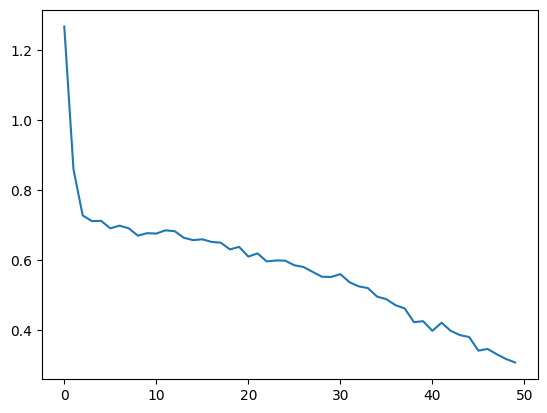

In [20]:
hidden_size = 256
teacher_forcing_ratio = 1
encoder0 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder0 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder0, decoder0, 5000, print_every=500)

Можно посмотреть на некоторую пару предложений из обучающей выборки и оценить качество.

In [25]:
def evaluateRandomly(encoder, decoder, decoder_type=None, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        if decoder_type == 'attention':
            output_words, attentions = evaluate(encoder, decoder, pair[0], decoder_type)
        else:
            output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

Посмотрим качество (accuracy) нашей модели на тестовой выборке:

In [26]:
def accuracy_on_test(encoder, decoder,  dataset_test, decoder_type = None):
    i = 0
    n = 0
    for pair in dataset_test:
        pred = []
        if decoder_type == 'attention':
            output_words, attentions = evaluate(encoder, decoder, pair[0] , decoder_type)
        else:
            output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        n += 1
        i += int(output_sentence[:10]== pair[1][:10])
    return i*1. /n

In [27]:
dataset_test = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')
accuracy_on_test(encoder0, decoder0, dataset_test[:100])

0.12

In [28]:
evaluateRandomly(encoder0, decoder0)

> 03-Nov-17
= 03-11-2017
< 03-01-2017<EOS>

> 25/01/17
= 25-01-2017
< 23-12-2017<EOS>

> 19-Aug-17
= 19-08-2017
< 18-09-2017<EOS>

> August 01th, 2018
= 01-08-2018
< 07-01-2018<EOS>

> 04 Oct 2018
= 04-10-2018
< 04-04-2018<EOS>

> Dec 06, 2018
= 06-12-2018
< 06-01-2018<EOS>

> Jun 15, 2018
= 15-06-2018
< 15-09-2018<EOS>

> December 14th, 2017
= 14-12-2017
< 24-11-2017<EOS>

> 07.01.2017
= 07-01-2017
< 08-01-2017<EOS>

> Oct 04, 2018
= 04-10-2018
< 04-04-2018<EOS>



Теперь обучим модель с attention декодером, параметры энкодера и количество эпох оставим те же:

(500 10%) 0.9122
(1000 20%) 0.6786
(1500 30%) 0.6274
(2000 40%) 0.5027
(2500 50%) 0.3979
(3000 60%) 0.3481
(3500 70%) 0.3017
(4000 80%) 0.2172
(4500 90%) 0.1764
(5000 100%) 0.1336


<Figure size 640x480 with 0 Axes>

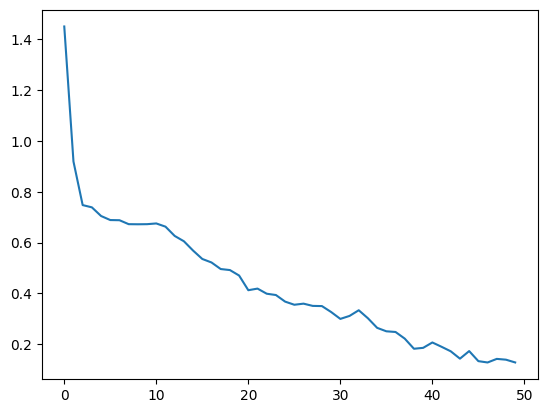

In [29]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 5000, decoder_type = 'attention', print_every=500)

In [30]:
evaluateRandomly(encoder1, attn_decoder1, decoder_type='attention')

> 14/01/2018
= 14-01-2018
< 14-01-2018<EOS>

> 27.09.2017
= 27-09-2017
< 27-09-2017<EOS>

> 06/12/17
= 06-12-2017
< 06-12-2018<EOS>

> February 17th, 2018
= 17-02-2018
< 10-09-2018<EOS>

> 16.12.2017
= 16-12-2017
< 16-12-2018<EOS>

> 07/08/18
= 07-08-2018
< 07-08-2018<EOS>

> 23 September 2018
= 23-09-2018
< 23-09-2018<EOS>

> 05-Jun-18
= 05-06-2018
< 05-06-2018<EOS>

> 17-Nov-17
= 17-11-2017
< 17-11-2017<EOS>

> Aug 19, 2018
= 19-08-2018
< 18-09-2018<EOS>



Сравним качество на тех же тестовых данных, что первую модель:

In [31]:
accuracy_on_test(encoder1, attn_decoder1, dataset_test[:100], decoder_type='attention')

0.58

Видим ощутимый прирост качества!
Еще один плюс использования механизма attention - получившиеся в ходе обучения веса можно визуализировать и интерпретировать.

In [32]:
def showAttention(input_sentence, output_words, attentions):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence, decoder_type='attention')
    print('input =', input_sentence)
    print('output =', ''.join(list(output_words)))
    showAttention(input_sentence, output_words, attentions)

input = 05 October 2018
output = 05-10-2018<EOS>


<ipython-input-32-b0de98347225>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-32-b0de98347225>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


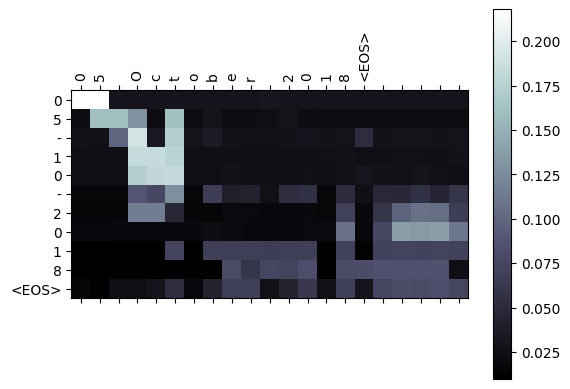

In [33]:
evaluateAndShowAttention("05 October 2018")

In [34]:
plt.clf()

<Figure size 640x480 with 0 Axes>

input = 04/01/2018
output = 04-01-2018<EOS>


<ipython-input-32-b0de98347225>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-32-b0de98347225>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


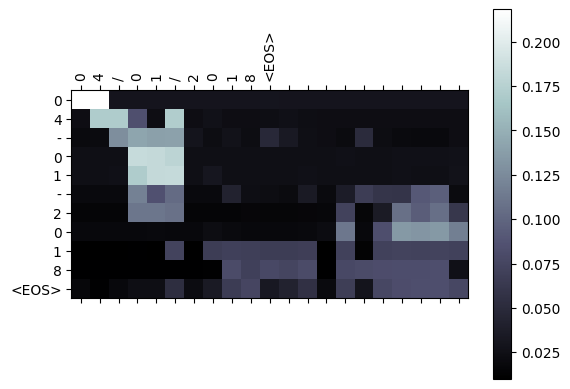

In [35]:
evaluateAndShowAttention("04/01/2018")

input = December 17th, 2018
output = 18-12-2018<EOS>


<ipython-input-32-b0de98347225>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-32-b0de98347225>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


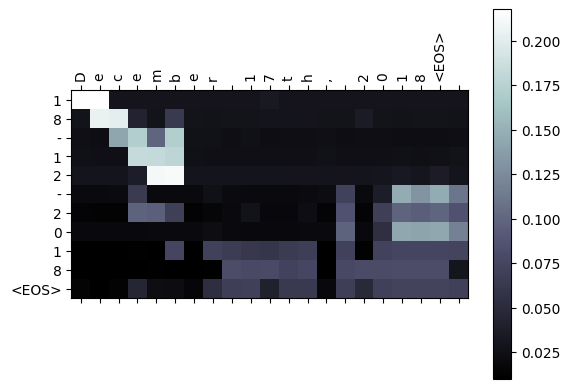

In [36]:
evaluateAndShowAttention("December 17th, 2018")

input = Feb 03, 2018
output = 03-02-2018<EOS>


<ipython-input-32-b0de98347225>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
<ipython-input-32-b0de98347225>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


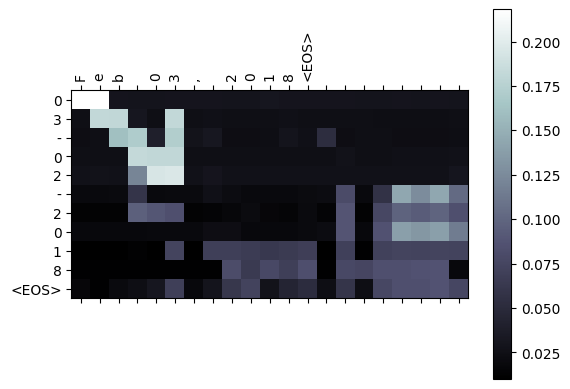

In [37]:
evaluateAndShowAttention("Feb 03, 2018")